# Het uitgebreide SIR model

Voor het eindproduct heb ik een SIER-model gemaakt die rekening houdt met de IC capaciteit. Daarnaast creeërt het programma ook grafieken over de sterftecijfers en het aantal overledenen per dag. Ik ga het model stap voor stap uitleggen, maar aangezien er ook veel stukken tussen staan die niet goed uit te leggen zijn zal niet alles worden toegelicht.

Om zelf het model te gebruiken moet je bij alle vakjes waarde code in staat shift+Enter klikken. Vooral het eerste blok zal even duren maar daarna zullen de blokken redelijk snel laden. Aan het einde geef ik nog een toelichting hoe je zelf het model kan gebruiken.

In [1]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install pandas

     |████████████████████████████████| 15.3 MB 3.7 MB/s eta 0:00:01    |██████▌                         | 3.1 MB 3.7 MB/s eta 0:00:04�███████▏   | 13.5 MB 3.7 MB/s eta 0:00:01     |███████████████████████████████▋| 15.1 MB 3.7 MB/s eta 0:00:01
     |████████████████████████████████| 11.5 MB 2.8 MB/s eta 0:00:01    |▍                               | 122 kB 2.8 MB/s eta 0:00:05     |▉                               | 317 kB 2.8 MB/s eta 0:00:05     |█▊                              | 634 kB 2.8 MB/s eta 0:00:04     |██▍                             | 849 kB 2.8 MB/s eta 0:00:04     |███▎                            | 1.2 MB 2.8 MB/s eta 0:00:04
     |████████████████████████████████| 2.2 MB 23.7 MB/s eta 0:00:01ta 0:00:01
     |████████████████████████████████| 1.1 MB 12.2 MB/s eta 0:00:01
     |████████████████████████████████| 27.4 MB 71 kB/s  eta 0:00:01    |███▏                            | 2.7 MB 4.4 MB/s eta 0:00:06███████████████▉          | 18.6 MB 4.4 MB/s eta 0:00:02     |████████

In [8]:
# importeren van belangrijke functies in het programma
import numpy as np  # module met cijferverwerking
import matplotlib.pyplot as plt  # module voor grafische weergave
import matplotlib.dates as mdates # module voor het verwerken van data
from scipy.integrate import odeint  # module voor integreren
import pandas as pd # een module voor het maken van dataframes

### Plot functie

Onder staat de functie voor het genereren van de grafieken. In totaal zullen er vier grafieken worden gemaakt. Eentje van het SEIR-model, een over de verandering van R0, een over de sterftecijfer (zowel dagelijks als totaal) en een grafiek voor het aantal doden per dag en of die doden zijn veroorzaakt door overbelasting van de IC.

In [14]:
"""
    Hier staan alle parameters uitgelegd voor de functie. Het zijn vooral datalijsten, waarvoor alle tijdseenheden
    al de waardes bekend zijn. Omdat we alle waardes al hebben in een datalijst kunnen we de lijnen tekenen:
    
    Positional args
    t = het aantal dagen, hier fungeert het als een parameter voor een van de formules
    S = een datalijst met alle waardes voor S (vatbaar)
    E = een datalijst met alle waardes voor E (blootgesteld)
    I = een datalijst met alle waardes voor I (besmettelijk)
    R = een datalijst met alle waardes voor R (genezen)
    C = een datalijst met alle waardes voor C (kritieke toestand)
    D = een datalijst met alle waardes voor D (overleden)
    R0 = een datalijst met alle waardes voor de R0 waarde
    B = een datalijst met alle waardes voor bedden
    
    keyword args
    I_to_C = de kans dat mensen van het I compartiment naar het C compartiment gaan
    C_to_D = de kans dat mensen van het C compartiment naar het D compartiment gaan
    x_as = een pandas dataframe waardoor een datum zichtbaar is op de x-as.
"""



def plotter(t, S, E, I, R, C, D, R0, B, I_to_C=None, C_to_D=None, x_as: "pandas dataframe" =None):
    
    # hier print ik een bericht zodat de percentages duidelijk worden voor de gebruiker
    print("percentage op de IC komt: {0}; percentage die sterft op de IC: {1}".format(I_to_C*100, C_to_D*100))
    
    # hier creër ik een plot, teken ik alle lijnen en geef ik de lijnen een label
    f, ax = plt.subplots(1, 1, figsize=(20, 4))
    ax.plot(x_as, S, 'b', alpha=0.7, linewidth=2, label='Vatbaar')
    ax.plot(x_as, E, 'y', alpha=0.7, linewidth=2, label='Blootgesteld')
    ax.plot(x_as, I, 'r', alpha=0.7, linewidth=2, label='Besmettelijk')
    ax.plot(x_as, C, 'c--', alpha=0.7, linewidth=2, label='Kritieke Toestand')
    ax.plot(x_as, R, 'g', alpha=0.7, linewidth=2, label='Genezen')
    ax.plot(x_as, D, 'k', alpha=0.7, linewidth=2, label='Overleden')
    
    # hier maak ik labels met maanden voor op de x-as en formateer ik het
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%d-%m'))
    f.autofmt_xdate()
    
    # ik geef een titel, maak een rooster en een legenda, en ik maak de randen onzichtbaar
    ax.title.set_text('Uitgebreid SIR Model')
    ax.grid(b=True, which='major', c='gray', lw=1, ls='--')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.7)
    for side in ( 'top', 'right', 'bottom', 'left'):
        ax.spines[side].set_visible(False)
    
    # laat de plot zien
    plt.show()

    
    # hier maak ik de grafiek voor de verandering van R0
    # ik maak hier een plot waar drie grafieken in passen en maak een grafiek op de eerste plaats voor de waarde van R0
    f = plt.figure(figsize=(20, 4))
    ax1 = f.add_subplot(1, 3, 1)
    ax1.plot(x_as, R0, 'r--', alpha=0.7, linewidth=2, label='R0')
    
    # hier maak ik labels met maanden voor op de x-as en formateer ik het
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%d-%m'))
    f.autofmt_xdate()
    
     # ik geef een titel, maak een rooster en een legenda, en ik maak de randen onzichtbaar
    ax1.title.set_text('Verandering van R0')
    ax1.grid(b=True, which='major', c='gray', lw=1, ls='--')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.7)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    # De sterftecijfer, zowel dagelijks als het cummulatieve gemiddelde
    # ik maak hier een grafiek op de tweede plaats
    ax2 = f.add_subplot(1, 3, 2)
    """
        Ik bereken hier de totale sterftecijfer en de dagelijkse sterftecijfer. De redenatie achter de formules zal ik verklaren.
        
        Voor de Totale sterftecijfer (in de code staat total_CFR):
        De totale sterftecijfer is (100 x (alle doden) / (cummulatief aantal besmettingen)). Ik zal illustreren dat dit klopt
        met een makkelijk voorbeeld. Stel er zijn 100 mensen besmet en 10 daarvan zijn overleden. Dan is het sterftecijfer
        (100 x 10/ 100) = 10%. En we zien meteen dat dit klopt. Het idee achter de translatie naar python is redelijk intuïtief.
        D[i] geeft het aantal doden tot tijdstip i aan. sigma * E[:i] geeft alle mensen aan die van het compartiment Blootgesteld
        naar het compartiment Besmettelijk zijn gegaan tot tijdstip i. Oftewel, het zijn alle mensen die besmet zijn tot dat 
        tijdstip! Als we hiervan de som nemen met de functie sum(x) dan hebben we het cumulatief aantal besmettingen.
        Dan hebben we de waarde voor de totale sterftecijfer op tijdstip i en door de functie: for i in range(1, len(t)),
        herhalen we dit voor alle tijdstippen tot de grootte van t en verzamelen we deze in een datalijst.
        Met die datalijst kunnen we een grafiek tekenen. 
        
        Voor de dagelijkse sterftecijfer (in de code staat daily_CFR):
        De dagelijkse sterftecijfer is (100 x ((alle doden op een dag) / ((alle genezen op een dag) + (alle doden op een dag))))
        Dit klopt omdat we benieuwd zijn naar de verhouding tussen leven en dood van voltooide ziektetrajecten. Aangezien je alleen
        kan genezen of sterven, zijn alle voltooide ziektetrajecten of genezen of dood. Weer een makkelijk voorbeeld om deze formule
        te illustreren. Stel 100 ziektetrajecten zijn afgelopen. 10 daarvan zijn overleden en 90 dus genezen. dan is het
        sterftecijfer (100 x ((10)/ (90 + 10))) dan krijgen we 10%, weer is het intuïtief duidelijk dat het klopt. Deze translatie
        naar python is wat ingewikkelder om te begrijpen zonder een achtergrond in programmeren. D[i]- D[i-1] betekent alle doden
        tot en met tijdstip i min alle doden van de dag voor tijdstip i. Hierdoor houd je alleen de doden over van tijdstip i. 
        R[i] - R[i-1] werkt hetzelfde. Door de functie: for i in range(1, len(t)),
        krijgen we weer een datalijst met alle waardes voor i. Daarmee kunnen we een grafiek plotten.
    """
    total_CFR = [0] + [100 * D[i] / sum(sigma * E[:i]) if sum(sigma * E[:i]) > 0 else 0 for i in range(1, len(t))]
    daily_CFR = [0] + [100 * ((D[i] - D[i - 1]) / ((R[i] - R[i - 1]) + (D[i] - D[i - 1]))) if max((R[i] - R[i - 1]), (
                D[i] - D[i - 1])) > 5  else 0 for i in range(1, len(t))]
    
    # hier maak ik een plot met twee lijnen
    ax2.plot(x_as, total_CFR, 'r--', alpha=0.7, linewidth=2, label='Totaal')
    ax2.plot(x_as, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='Dagelijks')
    
    # hier maak ik labels met maanden voor op de x-as en formateer ik het
    ax2.xaxis.set_major_locator(mdates.MonthLocator())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%d-%m'))
    f.autofmt_xdate()
    
    # ik geef een titel, maak een rooster en een legenda, en ik maak de randen onzichtbaar
    ax2.title.set_text('Sterftecijfer (%)')
    ax2.grid(b=True, which='major', c='gray', lw=1, ls='--')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.7)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
        

    # De doden per dag, ook wordt vermeld of het veroorzaakt is door een tekort aan IC Bedden
    # ik maak hier een grafiek op de derde plaats
    ax3 = f.add_subplot(1, 3, 3)
    
    # ik maak een datalijst met alle nieuwe doden op tijdstip i (ik gebruik weer D[i] - D[i - 1]. zie boven)
    new_D = [0] + [D[i] - D[i - 1] for i in range(1, len(t))]

    # ik plot de grafiek voor nieuwe doden
    ax3.plot(x_as, new_D, 'r--', alpha=0.7, linewidth=2, label='Totaal')
    
    # hier plot ik hoeveel doden zijn veroorzaakt door overbelasting van de IC
    # dit is makkelijk na te gaan want alle kritieke toestanden C zonder bed B hebben 100% kans om naar compartiment D te gaan
    ax3.plot(x_as, [max(0, C[i] - B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2,
             label="Doden door IC overbelasting")
    
    # hier maak ik labels met maanden voor op de x-as en formateer ik het
    ax3.xaxis.set_major_locator(mdates.MonthLocator())
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%d-%m'))
    f.autofmt_xdate()
    
    # ik geef een titel, maak een rooster en een legenda, en ik maak de randen onzichtbaar
    ax3.title.set_text('Doden per dag')
    ax3.grid(b=True, which='major', c='gray', lw=1, ls='--')
    legend = ax3.legend()
    legend.get_frame().set_alpha(0.7)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
        
    # hier toon ik het plaatje met de drie grafieken
    plt.show()

### Afgeleide functie

Hieronder staat de functie voor de afgeleides van alle waardes die veranderen naarmate de tijd verloopt. Dit zijn S, E, I, R, C en D. We gebruiken afgeleides omdat het moeilijk is om de orginele waardes te beschrijven, maar het relatief simpel is om de veranderingen te beschrijven. Hoe je bij de afgeleides komt zal ik hier uitleggen. 

S (vatbaar):
S' = -ß(t) x I x (S/N) is de afgeleide
ß is het aantal personen dat een besmet persoon besmet per dag
I is het aantal besmettelijke mensen
S is het aantal vatbare mensen
N is het complete aantal mensen

Dit klopt, want S neemt af met het aantal mensen dat geïnfecteerd raakt. Dit valt te berekenen met de waarde van ß keer het aantal besmettelijke mensen. Echter zal niet iedereen die een besmettelijk persoon tegenkomt nog vatbaar zijn. Sommigen zullen ook al geïnfecteerd zijn of zijn geweest. Daarom vermenigvuldig je ß x I nog met de verhouding van vatbaren met de complete populatie (S/N). 

E (blootgesteld):
E' = ß(t) x I x (S/N) - ς x E
ς is  1/(de lengte van de incubatie periode)
E is het aantal blootgestelde mensen

Dit klopt, want E neemt toe met het aantal mensen dat besmet raakt en dus van S naar E vloeit. E neemt af met het aantal mensen dat ook besmettelijk raakt. Dat is zodra de incubatie periode voorbij is. Dus stel er zijn 20 mensen geïnfecteerd met een incubatie periode van 5 dagen. Dan zijn er gemiddeld 20 x (1/5) = 4 mensen de volgende dag besmettelijk. Dus neemt het compartiment E af met ς x E.

I (besmettelijk):
I' = ς x E - 1/10.75 x p_I_to_C x I - γ x (1 - p_I_to_C) x I
γ is 1/(het aantal dagen dat iemand besmettelijk is)
p_I_to_C is de kans dat iemand van geïnfecteerd naar kritiek gaat

Dit klopt, want I neemt toe met het aantal mensen dat van compartiment E besmettelijk raakt. I neemt af met het aantal mensen die in kritieke toestand raken, want die gaan in isolatie. I neemt ook af met het aantal mensen die genezen.
De formule voor mensen die in kritieke toestand raken is 1/10.75 x p_I_to_C x I. Dit is logisch, want in totaal gaan I x p_I_to_C naar de IC, echter zal dit niet meteen gaan. Volgens het amerikaanse RIVM, de CDC, duurt het gemiddeld ongeveer 10.75 dagen voordat iemand van besmettelijk naar kritiek gaat. Daarom vermenigvuldigen wij I x p_I_to_C met 1/10.75 waardoor je 1/10.75 x p_I_to_C x I krijgt. 
De formule voor mensen die genezen is γ x (1 - p_I_to_C) x I. Het deel dat niet naar de IC gaat zal dus zonder complicatie genezen. Dus is die kans 1 - p_I_to_C. Het aantal mensen dat dus geneest is (1 - p_I_to_C) x I. Dit gaat niet meteen, want er is een gemiddeld aantal dagen dat iemand besmettelijk is. Dus vermenigvuldig je (1 - p_I_to_C) x I nog met γ. Waardoor je uiteindelijk γ x (1 - p_I_to_C) x I krijgt. 
Gezien I zowel met het aantal kritieke als genezen mensen afneemt doe je:
ς x E -(1/10.75 x p_I_to_C x I + γ x (1 - p_I_to_C) x I) wat uiteindelijk resulteert tot
I' = ς x E - 1/10.75 x p_I_to_C x I - γ x (1 - p_I_to_C) x I

C (kritieke toestand):
C' = 1/10.75 x p_I_to_C x I - 1/26 x p_C_to_D x min(Bed(t), C) - max(0, C-Bed(t)) - (1 - p_C_to_D) x 1/12 x min(Bed(t), C)
p_C_to_D is de kans van kritiek naar dood
min(Bed(t), C) de kleinste tussen de waardes van het aantal bedden en het aantal kritieke patiënten
max(0, C-Bed(t)) de grootste tussen de waardes van 0 en het aantal kritieke patiënten - het aantal bedden

Het aantal nieuwe mensen C is het aantal mensen dat in compartiment I in een kritieke toestand belandt. Dus C neemt toe met 1/10.75 x p_I_to_C x I. Het neemt op drie manieren af. 
1. Door mensen die van een kritieke toestand genezen.
Dit staat gelijk aan (1 - p_C_to_D) x 1/12 x min(Bed(t), C). Het is namelijk de kans dat iemand niet dood gaat (1 - p_C_to_D) keer het aantal mensen dat zorg ontvangt, oftewel de kleinste waarde van het aantal bedden en het aantal kritieke patiënten. Want als er meer patiënten zijn dan bedden, kan een deel van de patiënten geen zorg ontvangen. Dus wordt de zorg bepaalt door het aantal bedden beschikbaar. Volgens het RIVM, duurde een gemiddelde IC opname 18,7 dagen tijdens de eerste golf. Uit mijn data-analyse van de IC opnames heb ik geschat dat het gemiddeld 12 dagen duurde om in een genezen toestand de IC te verlaten.  Dus vermenigvuldigen we (1 - p_C_to_D) x min(Bed(t), C) met 1/12. Tot slot hebben we dan (1 - p_C_to_D) x 1/12 x min(Bed(t),C).
2. Door mensen die sterven op de IC.
Dit staat gelijk aan 1/26 x p_C_to_D x min(Bed(t), C). De kans dat iemand dood gaat terwijl hij wel zorg ontvangt is p_C_to_D. Het aantal mensen dat zorg kan ontvangen is de kleinste waarde tussen het aantal bedden en kritieke patiënten. Oftewel min(Bed(t), C). Vervolgens moet het worden vermenigvuldigt door de gemiddelde tijd dat iemand op de IC ligt en sterft. Na mijn analyse op de IC opnames schat ik die waarde op 26. Daarom komen we uit op de formule 1/26 x p_C_to_D x min(Bed(t), C).
3. Mensen die sterven doordat er geen ruimte is op de IC.
Hiervoor is de formule max(0, C-Bed(t)). Als het aantal kritieke patiënten minus het aantal bedden groter is dan nul, zullen de patiënten zonder toegang tot een bed sterven. Er is namelijk geen kans dat iemand in een kritieke toestand het virus overleeft. Als C-Bed(t) kleiner is dan nul, zal deze formule als waarde nul hebben.

Aangezien C afneemt op alle drie de manieren, trekken we deze formules af van de toename op C. Dus onze uiteindelijke formule is:
C' = 1/10.75 x p_I_to_C x I - 1/26 x p_C_to_D x min(Bed(t), C) - max(0, C-Bed(t)) - (1 - p_C_to_D) x 1/12 x min(Bed(t), C)

R (genezen):
R' = γ x (1 - p_I_to_C) x I + (1 - p_C_to_D) x 1/12 x min(Bed(t), C).
R' is de som van het aantal mensen die uit compartiment I en compartiment C genezen.
Dit is dus de afname uit compartiment I die niet op de IC belandt:  γ x (1 - p_I_to_C) x I.
En de afname uit compartiment C die geneest: (1 - p_C_to_D) x 1/12 x min(Bed(t), C).
Deze moet je bij elkaar optellen en daardoor krijg je de formule 
R' = γ x (1 - p_I_to_C) x I + (1 - p_C_to_D) x 1/12 x min(Bed(t), C).

D (overleden):
D' = 1/26 x p_C_to_D x min(Bed(t), C) + max(0, C-Bed(t)).
D' is de som van het aantal mensen die uit compartiment C sterft. 
Dit zijn dus de formules 1/26 x p_C_to_D x min(Bed(t), C) en max(0, C-Bed(t)) bij elkaar opgeteld. Hierdoor krijg je de formule: D' = 1/26 x p_C_to_D x min(Bed(t), C) + max(0, C-Bed(t)).


Dit zijn alle afgeleides die ik in de functie gebruik. De bronnen voor de gevonden waardes staan hieronder:


https://www.cdc.gov/coronavirus/2019-ncov/hcp/clinical-guidance-management-patients.html

https://www.rivm.nl/documenten/verschil-tussen-eerste-en-tweede-golf-corona


In [15]:
# creatie van de fucntie. Variabele z zijn de beginwaarde voor alle compartimenten
def derivative(z: 'tuple of 6', t, beta, gamma, sigma, N, p_I_to_C, p_C_to_D, Bed):
    # configuratie van de beginwaardes
    S, E, I, C, R, D = z
    
    # de formules van de afgeleides omgezet in python
    dSdt = -beta(t) * I * S / N
    dEdt = beta(t) * I * S / N - sigma * E
    dIdt = sigma * E - 1/10.75 * p_I_to_C * I - gamma * (1 - p_I_to_C) * I
    dRdt = gamma * (1 - p_I_to_C) * I + (1 - p_C_to_D) * 1 / 12.0 * min(Bed(t), C)
    dCdt = 1/10.75 * p_I_to_C * I - 1/26.0 * p_C_to_D * min(Bed(t), C) - max(0, C-Bed(t)) - (1 - p_C_to_D) * 1/12.0 * min(Bed(t), C)
    dDdt = 1/26.0 * p_C_to_D * min(Bed(t), C) + max(0, C-Bed(t))
    
    # de functie keert deze waardes terug
    return dSdt, dEdt, dIdt, dCdt, dRdt, dDdt

### Logistische R0

Hoewel er complexe methodes bestaan om de R0 waarde te baseren op veel variabelen, heb ik gekozen voor een functie met een logistische regressie. Bij een lockdown vermindert de R-waarde en volgt het relatief nauwkeurig een logistische regressie. Een complexere methode was mogelijk, maar dat was buiten mijn kunnen om te realiseren. De formule die ik heb gebruikt is een standaard vorm voor logistische regressie.

In [16]:
# creatie van de functie
def logistic_R0(t, R0_start, k, x0, R0_end):
    return (R0_start - R0_end) / (1 + np.exp(-k * (-t + x0))) + R0_end

### Het model

Tot slot het model. Het bestaat uit drie delen die ik afzonderlijk uit ga leggen.

 Eerst hebben we een functie in het model die de beta waarde berekent. De beta waarde is hoeveel mensen een besmet persoon per dag infecteert. Dit doe je door de R0 waarde te multipliceren met de gamma waarde. R0 betekent namelijk het aantal mensen dat een besmet persoon infecteert. Bij een R0 van zes infecteert dus elk geïnfecteerd persoon nog zes anderen. Stel nu dat de gemiddelde aantal dagen dat een persoon besmettelijk is op drie zit. Dan kan je beredeneren dat 6 x (1/3) = 2. Dus dat een besmet persoon gemiddeld twee mensen per dag besmet.

Vervolgens hebben we nog een functie voor het aantal bedden. We willen namelijk simuleren dat een land de IC opschaalt om overbelasting op de IC te voorkomen. Hiervoor hebben we een relatief makkelijke formule in gebruik genomen. Eerst berekenen we hoeveel bedden er zich in het land bevinden met de formule: bed_0 = bed_per_100K / 100.000 x N. Deze waarde gebruiken we vervolgens als startwaarde voor een lineare functie. De lineare functie ziet er zo uit: bed_0 + s * bed_0 * t. s is een vaste constante, hoe hoger s, hoe sneller het land opschaalt. t is de verandering van tijd. 

Tot slot hebben we nog een formule voor de R0 uitgezet tegen tijd. Die bestaat uit een creatie van een datalijst voor alle waardes van de R0 voor elke dag. Aangezien we weten dat R0 x gamma = beta klopt. Weten we ook dat R0 = beta/gamma. Dat doen we dus voor alle waardes van t en compileren dat in een datalijst. 

In [17]:
"""
    k is een constante die de vorm van de logistische formule voor R0 beïnlvoedt. 
    x0 is de waarde van t waar R0 het hardste daalt en dus de logistische formule zich omheen oriënteert.
    s is een constante die de vorm van de lineare formule voor bedden beïnlvoedt.
    R0_start en R0_end zijn schattingen van de begin- en eindwaardes van de R0
    age_groups is de distributie van de leeftijdsgroepen:
    0-14
    15-29
    30-39
    40-49
    50-59
    60-69
    70-79
    80-89
    90+
"""


def Model(days, age_groups: 'list', bed_per_100k, R0_start, R0_end, k, x0, prob_I_to_C, prob_C_to_D, s):
    # functie die de beta waarde berekent via een logistische regressie van R0
    def beta(t):
        return logistic_R0(t, R0_start, k, x0, R0_end) * gamma
    
    # de grootte van de complete bevolking, berekend door alle mensen van alle leeftijdsgroepen bij elkaar op te tellen.
    N = sum(age_groups)
    
    # functie die een lineare functie creërt voor de groei van bedden
    def Bed(t):
        bed_0 = bed_per_100k / 100_000 * N
        return bed_0 + s * bed_0 * t  # 0.003
    
    # configuratie van de beginwaardes voor alle compartimenten
    z0 = N - 1.0, 1.0, 0.0, 0.0, 0.0, 0.0
    
    # dit bepaalt het domein van de grafiek
    t = np.linspace(0, days - 1, days)
    
    # hier worden de afgeleides van alle compartimenten geprimitiveerd zodat de lijnen kunnen worden getekend
    ret = odeint(derivative, z0, t, args=(beta, gamma, sigma, N, prob_I_to_C, prob_C_to_D, Bed))
    S, E, I, C, R, D = ret.T
    
    # een formule om een datalijst te maken van alle R0 waardes bij alle waardes van t
    R0_over_time = [beta(i) / gamma for i in range(len(t))]
    
    # deze functie keert deze waardes terug
    return t, S, E, I, C, R, D, R0_over_time, Bed, prob_I_to_C, prob_C_to_D

Nu we alle functies hebben bepaald kunnen we het model gebruiken. Eerst moeten we nog de waarden van gamma en sigma bepalen. De gemiddelde incubatie tijd is volgens de CDC 4.5 dagen, dus de sigma waarde staat gelijk aan 1.0/4.5. De gamma waarde is 1/de gemiddelde tijd dat een persoon besmettelijk is. De waarde die ik heb gevonden is 10.0 dagen. Gamma is dus 1.0/10.0. Het aantal IC bedden in Nederland voor de pandemie was 1150. Dit betekent dat er 6.61 IC bedden per 100K inwoners zijn. Na ongeveer 60 dagen wordt dit 1700, dus het wordt groter met een factor van 1,478. Dan moet de s waarde ongeveer 0,0246 zijn. Uit mijn observaties van de R-waarde heb ik ondervonden dat de startwaarde van de R0-waarde ongeveer 3.7 was en de eindwaarde was na de eerste lockdown ongeveer 0.74. De daalde het snelst ongeveer 50 dagen na de eerste besmetting dus x0 staat gelijk aan 50. Na wat vallen en opstaan heb ik de waarde voor k gelijk gezet aan 0.99. De kans dat iemand in kritieke toestand sterft op de IC heb ik gezet op 40%. 19% van de mensen krijgt ernstige symptomen en zal sterven zonder zorg, dus ik heb p_I_to_C gelijk gezet aan 19%. 

https://www.cdc.gov/coronavirus/2019-ncov/hcp/clinical-guidance-management-patients.html

https://www.health.harvard.edu/diseases-and-conditions/if-youve-been-exposed-to-the-coronavirus

https://www.rijksoverheid.nl/onderwerpen/coronavirus-covid-19/gezondheid-en-zorg/ic-plekken

https://jamanetwork.com/journals/jama/fullarticle/2769290#:~:text=Approximately%2080%25%20of%20patients%20hospitalized,to%20experience%20long%2Dlasting%20morbidity.

https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20)30633-4/fulltext


percentage op de IC komt: 19.0; percentage die sterft op de IC: 40.0


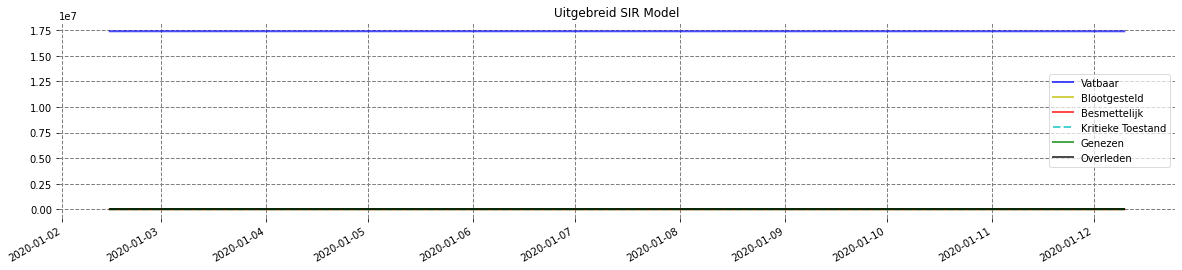

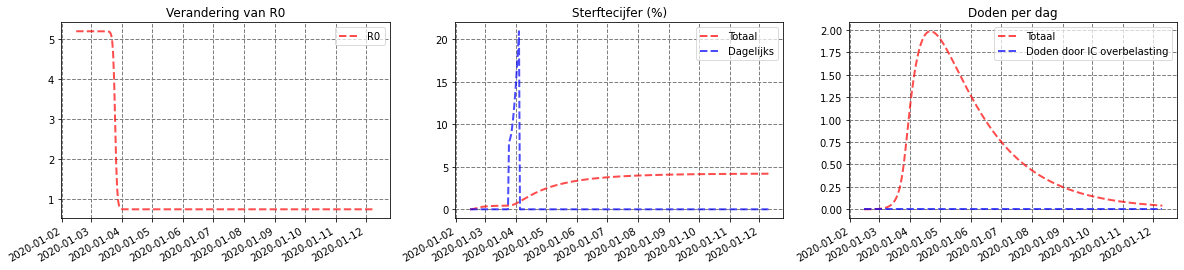

In [18]:
# het bepalen van de gamma en sigma variabelen
gamma = 1.0 / 10.0
sigma = 1.0 / 4.5

# bepalen wanneer de simulatie van start gaat en voor hoeveel dagen
x_as = pd.date_range(start='02/15/2020', periods=300, freq='D')

# hier vul ik alle waardes in het model
plotter(*Model(days=300, age_groups=[2_726_099, 3_282_708, 2_147_931, 2_208_076, 2_532_418, 2_113_846, 1_574_419,
                                     692_257, 129_831], bed_per_100k=6.61, R0_start=5.2, k=0.99, x0=39, R0_end=0.74,
               prob_I_to_C=0.19, prob_C_to_D=0.4, s=0.0246), x_as=x_as)

Je kan zelf ook het model veranderen. Hier even kort een handleiding:


Alle parameters die je vrij kunt veranderen:

gamma, sigma, bed_per_100K, R0_start, k, x0, R0_end, prob_I_to_C, prob_C_to_D

Alle parameters die je onder bepaalde omstandigheden kan veranderen:

let erop dat de age_group in totaal een waarde groter dan ongeveer 10.000 blijft.

als je wilt dat de grafiek langer of korter doorgaat moet je van de x_as parameter de periods veranderen en de days waarde naar het zelfde getal veranderen. 

In de laatste line moet je x_as=x_as met rust laten, behalve als je kennis hebt over pandas dataframes en je eigen data wilt toevoegen.

Hieronder heb ik een ludieke situatie bedacht, maar dan kan je wel goed de werking van het model zien.

percentage op de IC komt: 19.0; percentage die sterft op de IC: 50.0


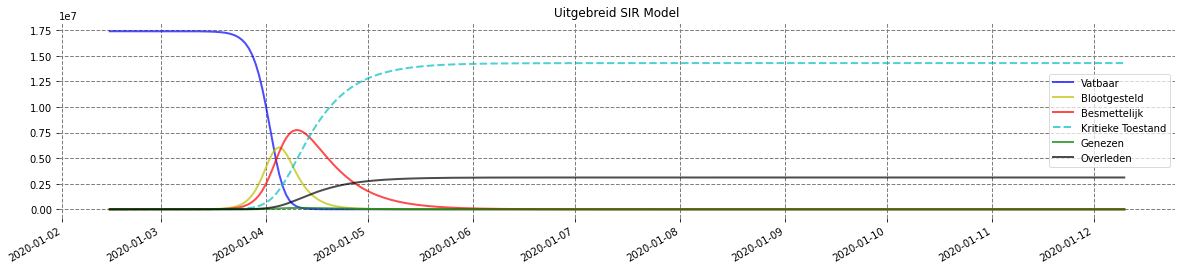

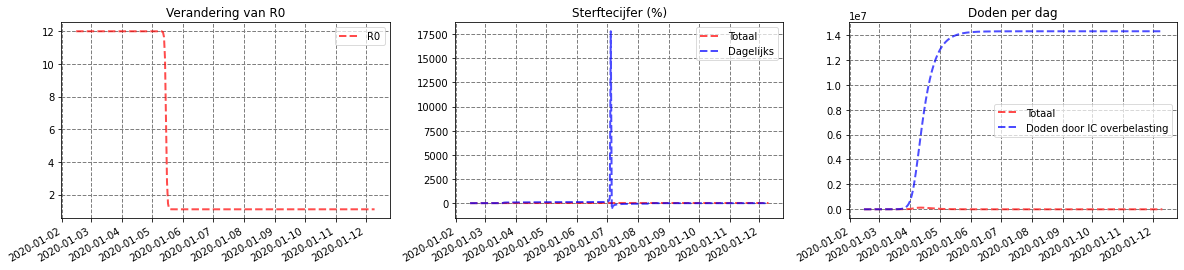

In [19]:
# bepalen wanneer de simulatie van start gaat en voor hoeveel dagen
x_as = pd.date_range(start='02/15/2020', periods=300, freq='D')

# hier vul ik alle waardes in het model
plotter(*Model(days=300, age_groups=[2_726_099, 3_282_708, 2_147_931, 2_208_076, 2_532_418, 2_113_846, 1_574_419,
                                     692_257, 129_831], bed_per_100k=5, R0_start=12.0, k=1.7, x0=90, R0_end=1.1,
               prob_I_to_C=0.19, prob_C_to_D=0.5, s=0.0046), x_as=x_as)